# TP : Word Embeddings for Classification

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import pprint
import pandas as pd
import gzip
from sklearn.model_selection import train_test_split
import string as st
import warnings 
pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.

In [2]:
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

print(rncp.head())

   Categorie                                text_certifications
0          1  Responsable de chantiers de bûcheronnage manue...
1          1  Responsable de chantiers de bûcheronnage manue...
2          1                                 Travaux forestiers
3          1                                              Forêt
4          1                                              Forêt


In [3]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [4]:
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [5]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


In [6]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k =4 
texts_reduced = texts[0::k]
labels_reduced = labels[0::k]

print('Number of documents:', len(texts_reduced))
print(texts_reduced[:10])

Number of documents: 23578
['Responsable de chantiers de bûcheronnage manuel et de débardage', 'Forêt', 'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité débardage', 'Arboriste-grimpeur', 'arboriste élagueur', 'Agrosciences, environnement, territoires, paysage, forêt (fiche nationale)', 'Technicien de rivière GEMAPI', 'Licence Professionnelle Mention Aménagement du paysage, Spécialité Aménagement et gestion écologiques des paysages urbains', 'Productions végétales spécialité Protection des cultures', 'Chargé de maintenance technique polyvalent']


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [7]:
x_train, x_test, labels_reduced, test_labels = train_test_split(texts_reduced,labels_reduced,random_state=42)

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer 
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pcd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Imports


#stemmer = PorterStemmer()
stemmer = WordNetLemmatizer()

def document_preprocessing(sentence):

    sentence = sentence.lower()
    tokens = nltk.word_tokenize(sentence)
    tokens = [token for token in tokens if token not in st.punctuation]
    stop_words = stopwords.words('french')
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)


<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
# Look at the data and apply the appropriate pre-processing
texts_reduced = [document_preprocessing(element) for element in texts_reduced]
x_train = [document_preprocessing(element) for element in x_train]
x_test = [document_preprocessing(element) for element in x_test]

print(texts_reduced[:10])

['responsable chantiers bûcheronnage manuel débardage', 'forêt', 'option chef ’ entreprise ohq travaux forestiers spécialité débardage', 'arboriste-grimpeur', 'arboriste élagueur', 'agrosciences environnement territoires paysage forêt fiche nationale', 'technicien rivière gemapi', 'licence professionnelle mention aménagement paysage spécialité aménagement gestion écologiques paysages urbains', 'production végétales spécialité protection culture', 'chargé maintenance technique polyvalent']


Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [66]:
from typing import Tuple, Dict

def create_vocabulary(texts) -> Tuple[Dict[str, int], np.ndarray]:
    vocabulary_set = set()
    [vocabulary_set.add(word) for text in texts for word in text.split()]
    vocabulary= {word: index for index, word in enumerate(vocabulary_set)}
    return vocabulary


vocabulary = create_vocabulary(texts_reduced)
print(f"Size of the vocabulary : {len(vocabulary)}")

Size of the vocabulary : 5028


What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Question:</div>

**Answer** :

A vocabulary size of 5028 can be appropriate depending on your dataset's size and diversity, and the specific NLP task,So based on the given dataset which is considered huge the vocabulary size should be kinda high, but here 5028 is considered very high and memory consuming and can cause some problem in addition if we perfom some task in nlp when we represent each document by a vector of 5028 it is terrible. 

solution:

Consider additional preprocessing like removing high-frequency and low-frequency words to refine the vocabulary. Utilizing techniques such as TF-IDF might help in emphasizing more relevant words. Adjusting vocabulary size based on model performance and error analysis is also advisable,especially those like n-gram, dimentionality reduction, or even using Neural netwrok embedding.

Experimentation with these elements will help in optimizing the effectiveness of your NLP model.

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# Assuming X_train and X_test are your training and test sets, and y_train and y_test are the labels
vectorizer = CountVectorizer(vocabulary=vocabulary)  # Replace 'your_own_vocabulary' with your predefined list of words
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

model = LogisticRegression(max_iter=300)
model.fit(X_train_vec, labels_reduced)
y_pred = model.predict(X_test_vec)


# print the accuracy 

print(f'The accuracy acheived by Logistic Regression is : {accuracy_score(test_labels,y_pred)}')

The accuracy acheived by Logistic Regression is : 0.22527565733672603


this is a very bad score since the logistic regression is designed to handel binary classification so here is not the case that is why we can see above a bad classification/

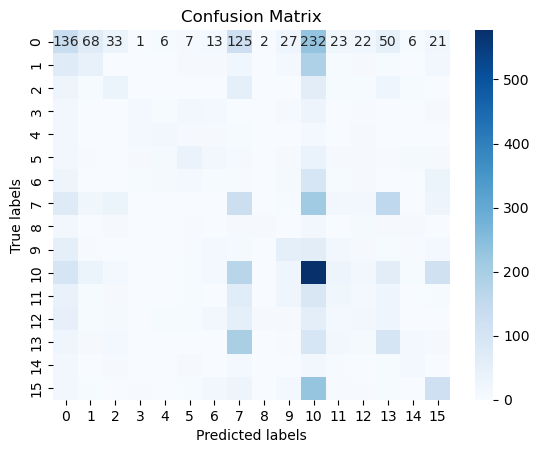

In [13]:
# Displaying the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary)  
X_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
X_test_tfidf = tfidf_vectorizer.transform(x_test)

model_tfidf = LogisticRegression(max_iter=300)
model_tfidf.fit(X_train_tfidf, labels_reduced)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

# display the score 

print(f'The accuracy acheived by Logistic Regression is : {accuracy_score(test_labels,y_pred_tfidf)}')


The accuracy acheived by Logistic Regression is : 0.24393553859202713


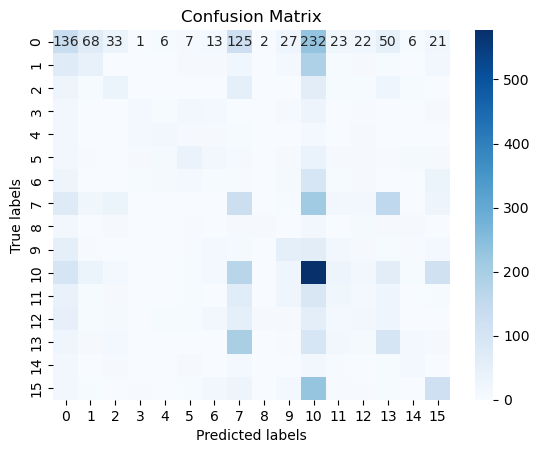

In [15]:
# Displaying the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
print(LogisticRegression().get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [20]:

from sklearn.model_selection import GridSearchCV

pramaters = {'max_iter':[100,250,350],'C':[0,0.5,0.7,1]}
model = LogisticRegression()
model_tuned = GridSearchCV(estimator=model,param_grid=pramaters,cv=5)

model_tuned.fit(X_train_vec,labels_reduced)




c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0, 0.5, 0.7, 1], 'max_iter': [100, 250, 350]})

In [21]:
# predict the model 

print(model_tuned.best_params_)

y_pred_tuned = model_tuned.best_estimator_.predict(X_test_vec)
print(f'The accuracy acheived by Logistic Regression is : {accuracy_score(test_labels,y_pred_tuned)}')

{'C': 0.5, 'max_iter': 100}
The accuracy acheived by Logistic Regression is : 0.23206106870229007


In [23]:
model = LogisticRegression()
pramaters = {'max_iter':[100,350],'C':[0,0.5]}
model_tuned = GridSearchCV(estimator=model,param_grid=pramaters,cv=5)

model_tuned.fit(X_train_tfidf,labels_reduced)

print(model_tuned.best_params_)



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'C': 0.5, 'max_iter': 350}


In [24]:
# predict the model 

y_pred_tuned_tfidf = model_tuned.best_estimator_.predict(X_test_tfidf)
print(f'The accuracy acheived by Logistic Regression is : {accuracy_score(test_labels,y_pred_tuned_tfidf)}')

The accuracy acheived by Logistic Regression is : 0.2532654792196777


## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

In [17]:

from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation

svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train_vec)
X_test_svd = svd.transform(X_test_vec)


In [18]:
lda = LatentDirichletAllocation(n_components=300, random_state=42, learning_method='batch')
X_train_lda = lda.fit_transform(X_train_vec)
X_test_lda = lda.transform(X_test_vec)



In [19]:
model_svd = LogisticRegression(max_iter=300)
model_svd.fit(X_train_svd, labels_reduced)
y_pred_svd = model_svd.predict(X_test_svd)
print("Accuracy with SVD:", accuracy_score(test_labels, y_pred_svd))

model_lda = LogisticRegression(max_iter=300)
model_lda.fit(X_train_lda, labels_reduced)
y_pred_lda = model_lda.predict(X_test_lda)
print("Accuracy with LDA:", accuracy_score(test_labels, y_pred_lda))

Accuracy with SVD: 0.24461407972858354
Accuracy with LDA: 0.24139100932994062


<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

To Answer this question we need score or test that allows us to compute the model's perfomance based on our course the best way to know if the model is good or not is to compute the perplexity for several value of data_dimension then we select that one that minimize the perplexity

see the following process:

In [102]:
perplexities = []


# define the number of iteration 

dimension_parameters = range(20,300,100)

for step in dimension_parameters:

    lda = LatentDirichletAllocation(n_components=step,random_state=42,learning_method='batch')

    # since the target is not the data only we need to know the value of perplexity so no need to store the data reduced 
    # lda can handle a sparce matrix 
    lda.fit(X_train_vec)
    perplexities.append(lda.perplexity(X_train_vec))
best_parameters = dimension_parameters[np.argmin(perplexities)]

print(f'this is the best parameters : {best_parameters}')

this is the best parameters : 20


[-5.64911669 -5.70907159 -7.07646246]


Text(0.5, 1.0, 'Perplexity vs. Number of Topics')

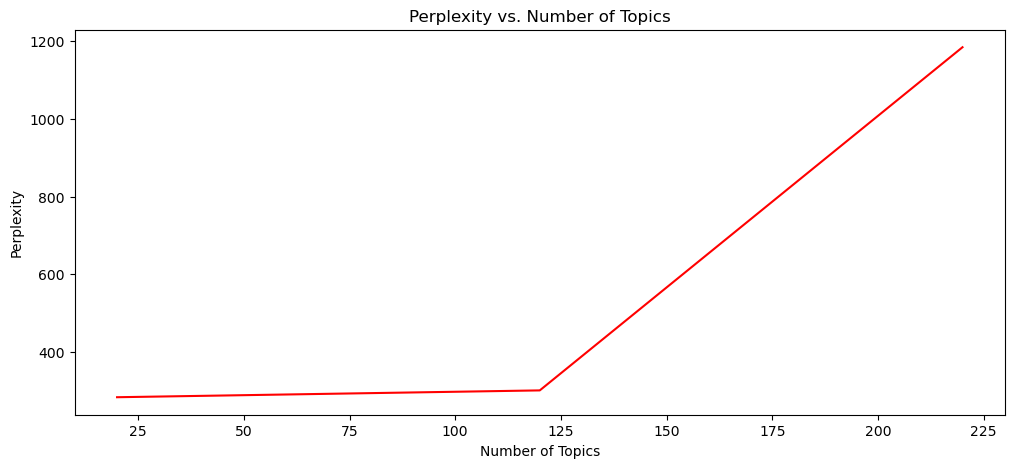

In [104]:
# ploting the perplexity function of the dimention 
print(-np.log(perplexities))
plt.figure(figsize=(12, 5))
plt.plot(dimension_parameters, perplexities, label='Perplexity',color= 'red')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Number of Topics')

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [20]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        #sent = " ".join(sent)
        # Obtain the indexes of the words in the sentence from the vocabulary
        sent_idx = [vocabulary[word] for word in sent.split()]

        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1) # This adds an Unkown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = [sent_idx[i - k] for k in range(1, window + 1) if i-k >= 0]
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = [sent_idx[k] for k in range(i)]
            # Go through the list and update M[i,j] and M[j,i]:        
            for j, ctx_idx in enumerate(l_ctx_idx):
                M[idx, ctx_idx] += 1
                M[ctx_idx,idx] = M[idx,ctx_idx]
    return M

<div class='alert alert-block alert-info'>
            Code:</div>

In [21]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension

def ppmi_matrix(M):
    """
    Transform a co-occurrence matrix into a PPMI matrix.
    
    Params:
        M (numpy.ndarray): The co-occurrence matrix
    Returns:
        PPMI (numpy.ndarray): The PPMI matrix
    """
    total = np.sum(M)
    row_sums = np.sum(M, axis=1)
    col_sums = np.sum(M, axis=0)
    expected = np.outer(row_sums, col_sums) / total
    
    epsilon = 1e-10 
    pmi = np.where(expected > 0, np.log((M + epsilon) / (expected + epsilon)), 0)
    ppmi = np.maximum(pmi, 0)
    
    return ppmi


In [22]:
def compute_svd(matrix, n_components=300):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    word_embeddings = svd.fit_transform(matrix)
    return word_embeddings

<div class='alert alert-block alert-info'>
            Code:</div>

In [94]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        indexes = [vocabulary[word] for word in text.split()] # Indexes of words in the sentence obtained thanks to the vocabulary
        sentrep = np_func(embeddings[indexes, :], axis = 0) # Embeddings of words in the sentence, aggregated thanks to the function
        representations.append(sentrep)
    representations = np.array(representations)    
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

def train_classifier(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(max_iter=3000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, y_pred, y_test  


In [25]:
co_occurrence_matrix_train = co_occurence_matrix(x_train, vocabulary)

ppmi_matrix_train = ppmi_matrix(co_occurrence_matrix_train)

word_embeddings = compute_svd(ppmi_matrix_train, n_components=300)

X_train = sentence_representations(x_train, vocabulary, word_embeddings, np_func=np.mean)
X_test = sentence_representations(x_test, vocabulary, word_embeddings, np_func=np.mean)

classifier, y_pred, y_test = train_classifier(X_train, labels_reduced, X_test, test_labels)

In [26]:
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

report = classification_report(y_test, y_pred)


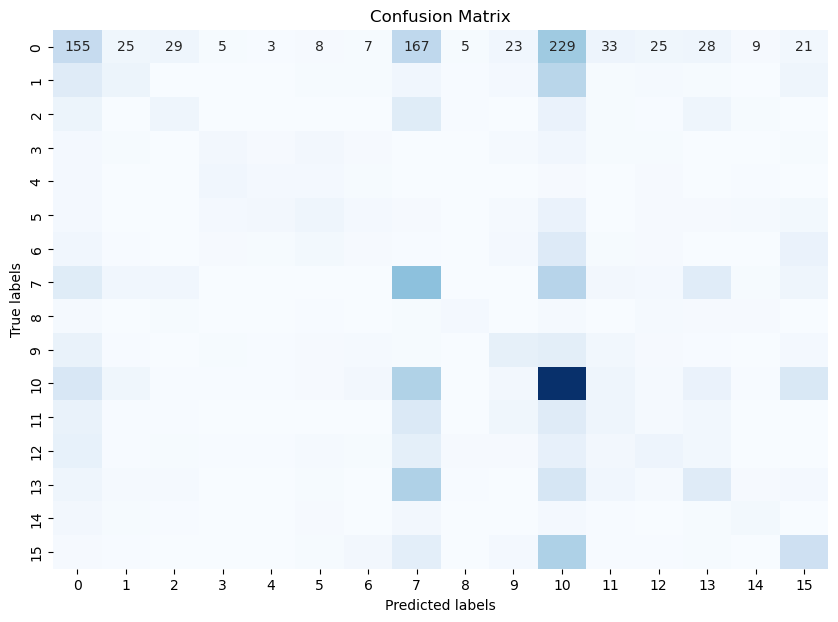

In [27]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)  
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:
print("Classification Scores:")
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("\nDetailed Classification Report:\n", report)


Classification Scores:
Accuracy: 25.67%
Precision: 0.23
Recall: 0.19
F1 Score: 0.20

Detailed Classification Report:
               precision    recall  f1-score   support

           1       0.22      0.20      0.21       772
          10       0.24      0.09      0.13       396
          11       0.23      0.12      0.16       229
          12       0.19      0.14      0.16       124
          13       0.20      0.13      0.16       100
          14       0.21      0.16      0.18       193
          15       0.09      0.04      0.05       223
          16       0.22      0.36      0.27       707
           2       0.35      0.16      0.22        86
           3       0.27      0.22      0.24       247
           4       0.32      0.52      0.40      1176
           5       0.15      0.10      0.12       311
           6       0.19      0.11      0.14       288
           7       0.23      0.15      0.18       494
           8       0.20      0.16      0.18        92
           9     

## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above. 

In [61]:
from gensim.models import Word2Vec
from collections import Counter
from nltk.tokenize import word_tokenize

In [81]:
all_words = [word for sentence in texts_reduced for word in sentence.split()]
word_counts = dict(Counter(all_words))
print("Word counts:", word_counts)


Word counts: {'responsable': 907, 'chantiers': 5, 'bûcheronnage': 1, 'manuel': 1, 'débardage': 2, 'forêt': 35, 'option': 1376, 'chef': 533, '’': 4371, 'entreprise': 164, 'ohq': 1, 'travaux': 279, 'forestiers': 7, 'spécialité': 9608, 'arboriste-grimpeur': 1, 'arboriste': 1, 'élagueur': 1, 'agrosciences': 29, 'environnement': 1094, 'territoires': 251, 'paysage': 117, 'fiche': 937, 'nationale': 1705, 'technicien': 411, 'rivière': 4, 'gemapi': 3, 'licence': 529, 'professionnelle': 1328, 'mention': 7310, 'aménagement': 402, 'gestion': 2948, 'écologiques': 5, 'paysages': 11, 'urbains': 45, 'production': 900, 'végétales': 56, 'protection': 303, 'culture': 336, 'chargé': 295, 'maintenance': 469, 'technique': 742, 'polyvalent': 45, 'aménagements': 13, 'paysagers': 14, 'cqp': 335, 'ouvrier': 20, 'construction': 315, "d'ouvrages": 4, 'sol': 42, 'sportifs': 40, 'engazonnés': 1, 'jardins': 9, 'espaces': 96, 'verts': 5, 'concepteur': 155, 'créateur': 12, 'jardin': 3, "d'équipe": 55, "d'entretien": 1

In [82]:
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts))
model.build_vocab_from_freq(word_counts)

<div class='alert alert-block alert-info'>
            Code:</div>

In [83]:

preprocessed_corpus = [word_tokenize(sentence) for sentence in texts_reduced]


In [84]:
model.train(preprocessed_corpus, total_examples=len(preprocessed_corpus), epochs=30, report_delay=1)

(3669178, 5538270)

In [86]:
x = model.wv.index_to_key
print("Words in vocabulary:",len(x))

Words in vocabulary: 2257


Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [104]:
vocab = {word: idx for idx, word in enumerate(model.wv.index_to_key)}
embedding_matrix = np.zeros((len(vocabulary), 300))


for word, idx in vocab.items():
    embedding_matrix[idx] = model.wv[word]  


In [109]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    representations = []
    for text in texts:
        indexes = [vocabulary[word] for word in text if word in vocabulary]
        if indexes:
            sent_rep = np_func(embeddings[indexes, :], axis=0)
            representations.append(sent_rep)
        else:
            representations.append(np.zeros(embeddings.shape[1],))
    return np.array(representations)

X_train = sentence_representations(x_train, vocab, embedding_matrix)
X_test = sentence_representations(x_test, vocab, embedding_matrix)


In [110]:
classifier = LogisticRegression(max_iter=3000, C=0.5)  
classifier.fit(X_train, labels_reduced) 
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(test_labels, y_pred)  

print(f"Classification Accuracy: {accuracy:.2f}")


Classification Accuracy: 0.20


<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ? 

**Answer** :

The primary issue that embeddings didn't resolve might be the lack of contextual relevance or insufficient data diversity, causing poor generalization. If embeddings from Word2Vec didn’t capture enough semantic nuances due to sparse or unrepresentative training data, the model may struggle with accuracy. In an industrial context, I'd propose using pre-trained embeddings from models like BERT or GPT, which offer richer contextual representations. Additionally, augmenting the dataset and incorporating more feature engineering to include syntactic and semantic metadata could enhance model robustness. Leveraging ensemble learning or more advanced deep learning architectures could also improve performance.